In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s3e12/train.csv")
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
# summary table function copied from https://www.kaggle.com/code/kimtaehun/simple-eda-and-baseline-in-2mintues

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ

summary(df)

data shape: (414, 8)


,data type,#missing,%missing,#unique,min,max
id,int64,0,0.0,414,0.000,413.00
gravity,float64,0,0.0,28,1.005,1.04
ph,float64,0,0.0,71,4.760,7.94
osmo,int64,0,0.0,80,187.000,1236.00
cond,float64,0,0.0,65,5.100,38.00
urea,int64,0,0.0,73,10.000,620.00
calc,float64,0,0.0,85,0.170,14.34
target,int64,0,0.0,2,0.000,1.00


<Axes: >

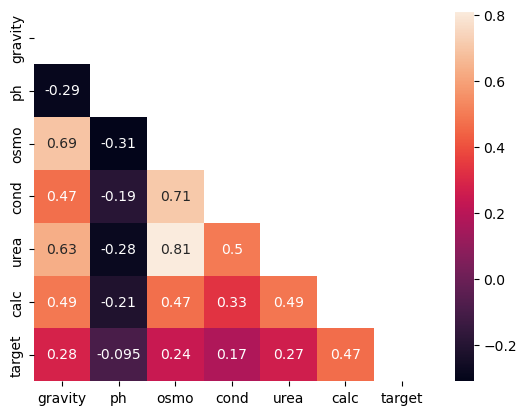

In [5]:
corr= df.drop('id',axis=1).corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

## Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
 
scaler= StandardScaler()

In [7]:
train = df.drop('id', axis=1)
test_raw = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv")
test = test_raw.drop('id', axis=1)

In [8]:
test.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


In [9]:
train_scaled = scaler.fit_transform(train.drop(['target'], axis=1)) 
test_scaled = scaler.transform(test) 

train_scaled = pd.DataFrame(train_scaled)
train_final=train_scaled.join(train['target'], how='inner')
train_final.columns = train.columns

test_final=pd.DataFrame(test_scaled)
test_final.columns = test.columns

In [10]:
test_final.head()

,gravity,ph,osmo,cond,urea,calc
0,-0.134053,-1.115319,-1.307829,-1.324056,-0.929406,-0.919373
1,0.315931,-0.429409,0.949065,1.007515,0.780342,-0.203699
2,0.915909,-0.928252,0.198189,-0.258195,0.552865,2.764794
3,0.315931,-0.975019,0.070199,0.514555,-0.195608,-0.203699
4,-1.034021,-0.133221,-0.360701,1.007515,1.308677,-0.545978


## Preparing model

In [11]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = train_final.drop(columns=['target'], axis=1), train_final[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.7596153846153846

In [14]:
preds=pd.DataFrame(preds)
ids=pd.DataFrame(test_raw['id'])
submission = ids.join(preds, how='inner')
submission.columns=['id', 'target']

In [15]:
submission.head()

,id,target
0,414,0
1,415,0
2,416,1
3,417,0
4,418,1


In [16]:
submission.to_csv('submission.csv',header=True,index=False)